<a href="https://colab.research.google.com/github/skadoosh4/trained_models/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
train_data = datasets.CIFAR10(root='data',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True,
                              target_transform=None)

test_data = datasets.CIFAR10(root = 'data',
                             train=False,
                             transform=transforms.ToTensor(),
                             download=True,
                             target_transform=None)

Files already downloaded and verified
Files already downloaded and verified


Image shape : torch.Size([3, 32, 32]) | Image Label : automobile


Text(0.5, 1.0, 'automobile')

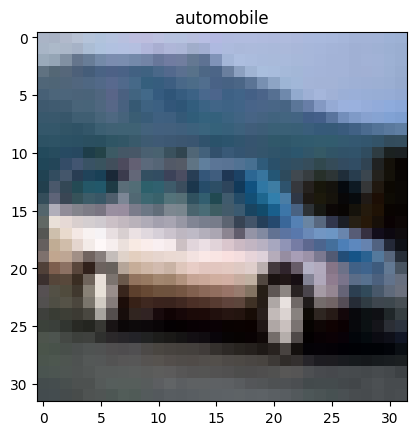

In [ ]:
image , label = train_data[4]
class_names = train_data.classes
class_names
print(f"Image shape : {image.shape} | Image Label : {class_names[label]}")
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])

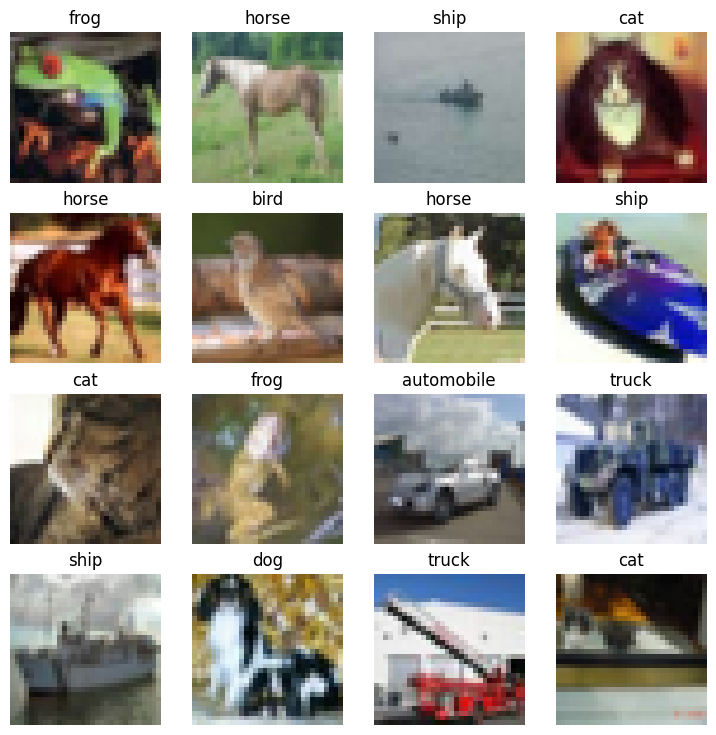

In [ ]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))

rows , cols = 4,4

for i in range (1 , rows*cols+1):
  random_idx = torch.randint(0 , len(train_data) , size=[1]).item()
  img , label = train_data[random_idx]
  fig.add_subplot(rows , cols , i)
  plt.imshow(img.permute(1,2,0))
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = 32,
                             shuffle = False)

In [ ]:
class CIFAR10Model(nn.Module):
  def __init__(self,
               input_shape : int,
               output_shape : int,
               hidden_units : int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels = hidden_units,
                  kernel_size = (3,3),
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = (3,3),
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.MaxPool2d(kernel_size = (2,2))
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = (3,3),
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = (3,3),
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.MaxPool2d(kernel_size=(2,2))
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = (3,3),
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = (3,3),
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.MaxPool2d(kernel_size=(2,2))
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units * 4 * 4,
                  out_features= 1024
                  ),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features= 1024,
                  out_features= 512),
        nn.ReLU(),
        nn.Linear(in_features= 512,
                  out_features=output_shape)
    )

  def forward(self , x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    return self.classifier(x)

In [ ]:
from pathlib import Path
import requests

if Path("helper_functions.py").is_file():
  print("Helper Functions already exists")
else :
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py" , "wb") as f:
    f.write(request.content)

Helper Functions already exists


In [ ]:
from timeit import default_timer as timer
def print_time(start : float , end : float , device : torch.device = None):
  total_time = end - start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

In [ ]:
def train_step(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn ,
               device : torch.device = device):

  train_loss , train_acc = 0,0

  model.train()

  for batch, (X,y) in enumerate(train_dataloader):
    X , y = X.to(device) , y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred , y)

    train_loss += loss

    acc = accuracy_fn(y_pred = y_pred.argmax(dim=1) , y_true = y)

    train_acc += acc

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss : {train_loss:.5f} | Train Acc : {train_acc:.2f}% \n")

In [ ]:
def test_step(model : torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn,
              device : torch.device = device):

  test_loss , test_acc = 0 , 0

  model.eval()

  with torch.inference_mode():
    for X , y in data_loader:
      X , y = X.to(device) , y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred , y)

      test_loss += loss

      acc = accuracy_fn(y_pred = y_pred.argmax(dim=1) , y_true = y)

      test_acc += acc

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss : {test_loss:.5f} | Test Acc : {test_acc:.2f}% \n")

In [ ]:
torch.manual_seed(42)

model = CIFAR10Model(input_shape=3,
                     output_shape=len(class_names),
                     hidden_units=64)
model

CIFAR10Model(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_blo

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.1)

from helper_functions import accuracy_fn

In [ ]:
torch.manual_seed(42)

epochs = 4

train_time_start = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}\n --------------------------------------------")

  train_step(model = model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)

  test_step(model = model,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)
  train_time_end = timer()
  total_train_time = print_time(start = train_time_start,
                              end = train_time_end,
                              device = device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0
 --------------------------------------------
Train Loss : 0.06808 | Train Acc : 97.65% 

Test Loss : 0.76382 | Test Acc : 82.98% 

Train time on cpu : 760.104 seconds
Epoch 1
 --------------------------------------------
Train Loss : 0.06767 | Train Acc : 97.66% 

Test Loss : 0.77731 | Test Acc : 83.26% 

Train time on cpu : 1313.859 seconds
Epoch 2
 --------------------------------------------
Train Loss : 0.06037 | Train Acc : 97.93% 

Test Loss : 0.78382 | Test Acc : 83.24% 

Train time on cpu : 1856.173 seconds
Epoch 3
 --------------------------------------------
Train Loss : 0.05514 | Train Acc : 98.19% 

Test Loss : 0.79864 | Test Acc : 82.99% 

Train time on cpu : 2397.240 seconds


In [ ]:
def make_predictions(model : torch.nn.Module,
                     data : list,
                     device : torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:

      sample = torch.unsqueeze(sample , dim=0).to(device)

      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze() , dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [ ]:
import random
test_samples = []
test_labels = []

for sample , label in random.sample(list(test_data) , k=16):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([3, 32, 32])

Text(0.5, 1.0, 'airplane')

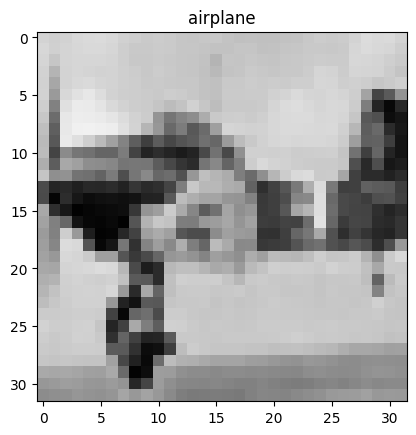

In [ ]:
plt.imshow(test_samples[0].permute(1,2,0))
plt.title(class_names[test_labels[0]])

In [ ]:
pred_probs = make_predictions(model = model,
                              data = test_samples,
                              device = device)

pred_probs[:1]
class_names[pred_probs[:1].argmax(dim=1).item()]
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 6, 5, 3, 2, 8, 1, 0, 0, 8, 5, 7, 1, 3, 6, 7])

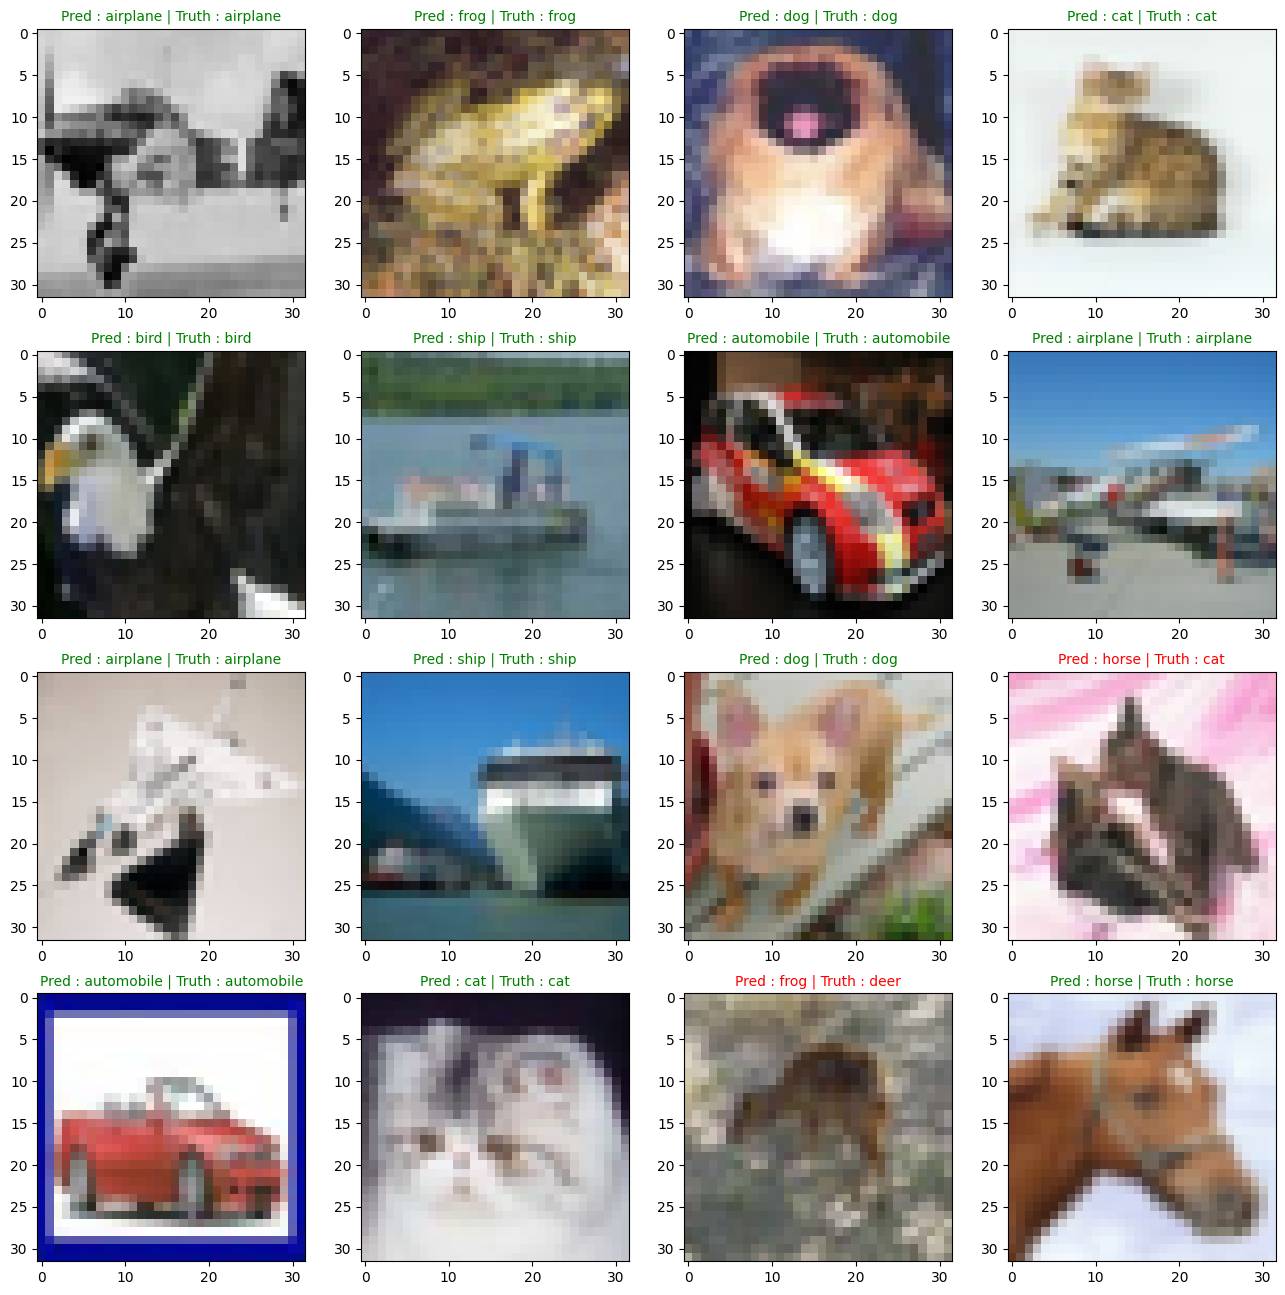

In [ ]:
from typing import NoReturn
plt.figure(figsize=(16,16))
nrows = 4
ncols = 4

for i , sample in enumerate(test_samples):
  plt.subplot(nrows , ncols , i+1)

  plt.imshow(sample.permute(1,2,0))

  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred : {pred_label} | Truth : {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text , fontsize = 10 , c='g')
  else:
    plt.title(title_text , fontsize = 10 , c='r')